中文字体启用： SimHei


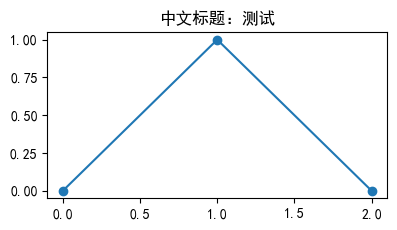

In [1]:
# ✓ Matplotlib 中文字体（无网络、不捕获异常）：仅在本机已有中文字体时启用
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

preferred = [
    "SimHei", "Microsoft YaHei", "PingFang SC", "Hiragino Sans GB",
    "Source Han Sans CN", "Source Han Sans SC", "Noto Sans CJK SC",
    "Noto Sans SC", "WenQuanYi Zen Hei", "Sarasa Gothic SC"
]
available = set(f.name for f in fm.fontManager.ttflist)
picked = ""
for name in preferred:
    if name in available:
        picked = name
        break

if picked:
    matplotlib.rcParams['font.sans-serif'] = [picked]
matplotlib.rcParams['axes.unicode_minus'] = False
print("中文字体启用：", picked if picked else "（未配置中文字体，使用默认）")

# 小测试
plt.figure(figsize=(4,2.4))
plt.title("中文标题：测试")
plt.plot([0,1,2],[0,1,0], "o-")
plt.tight_layout(); plt.show()


In [2]:
import torch

def demographic_parity_difference(y_true, y_pred, sensitive_attr):
    # y_true, y_pred, sensitive_attr 为长度相同的一维张量
    group0_mask = (sensitive_attr == 0)
    group1_mask = (sensitive_attr == 1)
    
    p0 = y_pred[group0_mask].float().mean()
    p1 = y_pred[group1_mask].float().mean()
    
    return torch.abs(p0 - p1)

# 使用示例
y_true = torch.tensor([1, 0, 1, 0, 1, 0])           # 实际标签
y_pred = torch.tensor([1, 0, 0, 0, 1, 1])           # 预测标签
sensitive_attr = torch.tensor([0, 0, 1, 1, 0, 1])   # 0 表示一组，1 表示另一组

dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_attr)
print(f"Demographic Parity Difference: {dp_diff.item():.4f}")


Demographic Parity Difference: 0.3333


In [3]:
import torch
import torch.nn as nn

class SimpleTabularNN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(n_features, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layer(x)

def feature_importance(model, X, baseline=None):
    model.eval()
    baseline = baseline if baseline is not None else torch.zeros_like(X)
    importances = []
    for i in range(X.shape[1]):  # 遍历特征维度
        X_perturbed = X.clone()
        X_perturbed[:, i] = baseline[:, i]
        with torch.no_grad():
            pred_original = model(X)
            pred_perturbed = model(X_perturbed)
        importance = (pred_original - pred_perturbed).abs().mean().item()
        importances.append(importance)
    return importances

# 样本数据和模型
X = torch.rand(100, 5)
model = SimpleTabularNN(n_features=5)
importances = feature_importance(model, X)
print("Feature importances:", importances)


Feature importances: [0.009378163143992424, 0.022481046617031097, 0.004732937086373568, 0.0034330887719988823, 0.01767401397228241]


In [4]:
import torch
import json
import datetime

def log_decision(user_id, input_features, prediction):
    log_entry = {
        "timestamp": datetime.datetime.now().isoformat(),
        "user_id": user_id,
        "input": input_features.tolist(),
        "prediction": prediction.item()  # 转为 Python 标量
    }
    with open("model_audit_log.json", "a") as f:
        f.write(json.dumps(log_entry) + "\n")

# 模拟预测与记录
user_features = torch.tensor([0.3, 0.7, 0.2])
model_pred = torch.tensor(1.0)  # 模拟预测结果
log_decision("user_123", user_features, model_pred)
print("日志记录完成")


日志记录完成


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class FairModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def fairness_penalty(preds, sensitive_attrs):
    # 惩罚不同群体之间预测率的差异
    group0_mean = preds[sensitive_attrs==0].mean()
    group1_mean = preds[sensitive_attrs==1].mean()
    return torch.abs(group0_mean - group1_mean)

# 样本数据
X_train = torch.rand(100, 5)
y_train = torch.bernoulli(torch.rand(100))
sensitive = torch.randint(0, 2, (100,))

model = FairModel(input_dim=5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    penalty = fairness_penalty(outputs, sensitive)
    total_loss = loss + 0.1 * penalty  # 权衡参数 0.1
    total_loss.backward()
    optimizer.step()

    # 每 10 轮打印一次
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Fairness penalty={penalty.item():.4f}")


Epoch 0: Loss=0.7329, Fairness penalty=0.0039
Epoch 10: Loss=0.7074, Fairness penalty=0.0040
Epoch 20: Loss=0.7034, Fairness penalty=0.0033
Epoch 30: Loss=0.6991, Fairness penalty=0.0018
Epoch 40: Loss=0.6947, Fairness penalty=0.0002
Epoch 50: Loss=0.6910, Fairness penalty=0.0012
Epoch 60: Loss=0.6876, Fairness penalty=0.0023
Epoch 70: Loss=0.6846, Fairness penalty=0.0033
Epoch 80: Loss=0.6819, Fairness penalty=0.0042
Epoch 90: Loss=0.6796, Fairness penalty=0.0050


In [7]:
import torch
import numpy as np
from sklearn.linear_model import LinearRegression

def generate_perturbations(x, num_samples=500):
    # 通过高斯噪声生成扰动样本
    perturbations = x + 0.1 * torch.randn(num_samples, x.size(1))
    return perturbations

def lime_explanation(model, x, num_samples=500):
    model.eval()
    X_perturbed = generate_perturbations(x.unsqueeze(0), num_samples)
    with torch.no_grad():
        y_perturbed = model(X_perturbed).squeeze().numpy()
    y_original = model(x.unsqueeze(0)).item()
    X_np = X_perturbed.numpy()
    y_np = y_perturbed
    lin_reg = LinearRegression()
    lin_reg.fit(X_np, y_np)
    feature_importance = lin_reg.coef_
    return feature_importance, y_original

# 使用示例
class DummyModel(torch.nn.Module):
    def forward(self, x):
        return torch.sigmoid(torch.sum(x, dim=1, keepdim=True))

model = DummyModel()
x = torch.tensor([0.5, 0.2, 0.1, 0.4])
feature_importance, prediction = lime_explanation(model, x)
print(f"Predicted: {prediction}")
print(f"Feature importances (local): {feature_importance}")

Predicted: 0.7685248255729675
Feature importances (local): [0.17421888 0.17458938 0.1750304  0.1768309 ]


In [8]:
import torch
import numpy as np
from sklearn.linear_model import LinearRegression

def approximate_shap(model, x, num_samples=100):
    model.eval()
    n_features = x.size(0)
    coalitions = torch.randint(0, 2, (num_samples, n_features))
    outputs, weights = [], []
    for i in range(num_samples):
        mask = coalitions[i]
        x_masked = x * mask.float()
        with torch.no_grad():
            pred = model(x_masked.unsqueeze(0)).item()
        outputs.append(pred)
        included = mask.sum().item()
        weight = (n_features - 1) / (included * (n_features - included) + 1e-6) if included > 0 else 0
        weights.append(weight)
    outputs = np.array(outputs)
    weights = np.array(weights)
    coalitions_np = coalitions.numpy()
    lin_reg = LinearRegression()
    lin_reg.fit(coalitions_np, outputs, sample_weight=weights)
    shap_values = lin_reg.coef_
    return shap_values

x = torch.tensor([0.6, 0.1, 0.4, 0.3])
shap_vals = approximate_shap(model, x)
print(f"Approximate SHAP values: {shap_vals}")

Approximate SHAP values: [0.1224647  0.01535129 0.08414234 0.05759526]


In [10]:
import torch
import torch.nn as nn

# 示例模型
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)

    def forward(self, x):
        return self.linear(x)

def integrated_gradients(model, inputs, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)
    
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(steps + 1)]
    grads = []

    for inp in scaled_inputs:
        inp = inp.clone().detach().requires_grad_(True)  # 确保是叶子节点
        output = model(inp.unsqueeze(0))
        model.zero_grad()
        output.backward()
        grads.append(inp.grad.detach().clone())  # 现在安全
    avg_grads = torch.mean(torch.stack(grads[:-1]), dim=0)
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

# 测试
x = torch.tensor([0.3, 0.7, 0.2], dtype=torch.float32)
model = DummyModel()
ig = integrated_gradients(model, x)
print("Integrated gradients:", ig)


Integrated gradients: tensor([ 0.1160, -0.3952, -0.0659])


In [11]:
import torch
from captum.attr import IntegratedGradients

def monitor_model_explanation(model, input_sample):
    model.eval()
    ig = IntegratedGradients(model)
    attributions = ig.attribute(input_sample.unsqueeze(0))
    # 打印或可视化归因结果，辅助审计
    print("Attributions:", attributions)

# 示例模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(4,1)
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

model = Model()
sample_input = torch.tensor([0.25, 0.5, 0.1, 0.7])
monitor_model_explanation(model, sample_input)

Attributions: tensor([[ 0.0006, -0.0374,  0.0024, -0.0002]])
